Benchmarking results files must be placed in the following manner:

```
- benchmarking-results
  - json-accuracy
    - llm-img2json
      - model
        - llm-img2json_<cleaning_method>_<time_str>.csv
        - ...
    - llm-txt2json
      - model
        - llm-txt2json_<cleaning_method>_<time_str>.csv
        - ...
  - txt-accuracy
    - llm-img2txt
      - model
        - <cleaning_method>_<time_str>.csv
        - ...
    - ocr-img2txt
      - ...
    - ocr-llm-img2txt
      - ...
```    

# Open multiple results files using Pandas

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import math

ROOT_DIR = Path.cwd().parent.parent

# For reference only
TXT_PARENT_DIR = ROOT_DIR / 'benchmarking-results' / 'txt-accuracy'
TXT_SUB_DIRS = ['llm-img2txt', 'ocr-img2txt', 'ocr-llm-img2txt']

JSON_PARENT_DIR = ROOT_DIR / 'benchmarking-results' / 'json-accuracy'
JSON_SUB_DIRS = ['llm-img2json', 'llm-txt2json']

# The columns of the dataframe that doesn't correspond to the columns
DF_INFO_COLS = ['sub_dir', 'cleaning_method', 'time_str', 'doc', 'metric']

def process_dfs(df: pd.DataFrame, sub_dir: str, filename: str) -> pd.DataFrame:
        """
        Returns a new dataframe with the following operations applied:
        - Adds the column `sub_dir`, which is the subdirectory the file is located in (i.e. img2json) found from the sub_dir parameter.
        - Adds the column `cleaning_method`, which contains either 'normalized', 'nonorm', or 'fuzzy' found from the cleaning_method parameter.
        - Adds the column `time_str`, which is a string representing the time of file creation found from the name parameter.
        - Splits the previously-unnamed column into a `doc` and `metric` column
        """
        old_cols = list(df.columns)
        new_cols = ["sub_dir", "cleaning_method", "time_str", "doc", "metric"] + old_cols

        # Filename format: assume the following; others are invalid
        # - llm-img2json_<cleaning_method>_<time_str>.csv
        # - llm-txt2json_<cleaning_method>_<time_str>.csv
        # - <cleaning_method>_<time_str>.csv

        filename_split = filename.split("_")
        cleaning_method = "_".join(filename_split[:-2]).removeprefix("llm-img2json_").removeprefix("llm-txt2json_")
        time_str = "_".join(filename_split[-2:]).removesuffix(".csv")

        processed_df = df.copy()
        processed_df["sub_dir"] = sub_dir
        processed_df["cleaning_method"] = cleaning_method
        processed_df["time_str"] = time_str
        processed_df["doc"] = processed_df["Unnamed: 0"].apply(lambda x: (x.split(":")[0]))
        processed_df["metric"] = processed_df["Unnamed: 0"].apply(lambda x: ":".join(x.split(":")[1:]))
        processed_df = processed_df[new_cols]
        processed_df = processed_df.drop(columns="Unnamed: 0")

        return processed_df


def open_benchmarking_results_folder(parent_dir: Path, sub_dir: str) -> pd.DataFrame:
    """
    Opens all of the benchmarking results within a single directory following the specified parameters.
    `search_pattern` is handled using glob.

    Returns a list with dataframes.
    """

    file_paths = (parent_dir / sub_dir).glob('*.csv')
    dataframes = [
        process_dfs(
            pd.read_csv(parent_dir / sub_dir / path), sub_dir, path.name
        ) for path in file_paths
    ]

    combined = pd.concat(dataframes, ignore_index=True)
    return combined


def open_all_benchmarking_results(parent_dir: Path, sub_dirs: list[str]):
    """
    Opens all of the benchmarking results for either text or JSON output.

    Returns a combined dataframe.
    """
    dataframes = [
        open_benchmarking_results_folder(parent_dir, sub_dir) for sub_dir in sub_dirs
    ]
    combined = pd.concat(dataframes, ignore_index=True)
    return combined


txt_bm = open_all_benchmarking_results(TXT_PARENT_DIR, TXT_SUB_DIRS)
json_bm = open_all_benchmarking_results(JSON_PARENT_DIR, JSON_SUB_DIRS)

# Text benchmarking results

In [185]:
txt_bm

,sub_dir,cleaning_method,time_str,doc,metric,gemini-2.5-flash,gpt-4o,pytesseract
0,llm-img2txt,nonorm,2025-07-16_12-01-57,kbaa-p003,dist_char,20.000000,10.000000,NaN
1,llm-img2txt,nonorm,2025-07-16_12-01-57,kbaa-p003,doc_len,2894.000000,2894.000000,NaN
2,llm-img2txt,nonorm,2025-07-16_12-01-57,kbaa-p003,cer_pct,0.691085,0.345543,NaN
3,llm-img2txt,nonorm,2025-07-16_12-01-57,kbaa-p003,wer_pct,3.311258,1.545254,NaN
4,llm-img2txt,nonorm,2025-07-16_12-01-57,kbaa-p003,token_sort_ratio,98.580269,99.854387,NaN
...,...,...,...,...,...,...,...,...
2635,ocr-llm-img2txt,normalized,2025-07-16_12-01-57,__ALL__,dist_char,5953.000000,2041.000000,NaN
2636,ocr-llm-img2txt,normalized,2025-07-16_12-01-57,__ALL__,doc_len,141889.000000,141889.000000,NaN
2637,ocr-llm-img2txt,normalized,2025-07-16_12-01-57,__ALL__,cer_pct,4.195533,1.438448,NaN
2638,ocr-llm-img2txt,normalized,2025-07-16_12-01-57,__ALL__,wer_pct,5.301682,1.475767,NaN


## Move pytesseract results alongside LLM results

In [186]:
# Split txt results to (llm-img2txt + ocr-llm-img2txt) and (ocr-img2txt)
llm_txt = txt_bm[txt_bm['sub_dir'] != 'ocr-img2txt']
ocr_txt = txt_bm[txt_bm['sub_dir'] == 'ocr-img2txt']

# Fill in llm-img2txt columns
for index, row in llm_txt.iterrows():
    cleaning_method = row['cleaning_method']
    time_str = row['time_str']
    doc = row['doc']
    metric = row['metric']

    ocr_metric = ocr_txt.loc[
        (ocr_txt['cleaning_method'] == cleaning_method) &
        (ocr_txt['time_str'] == time_str) &
        (ocr_txt['doc'] == doc) &
        (ocr_txt['metric'] == metric),
        'pytesseract'
    ]
    if not ocr_metric.empty:
        llm_txt.loc[index, 'pytesseract'] = ocr_metric.iloc[0]

llm_txt

,sub_dir,cleaning_method,time_str,doc,metric,gemini-2.5-flash,gpt-4o,pytesseract
0,llm-img2txt,nonorm,2025-07-16_12-01-57,kbaa-p003,dist_char,20.000000,10.000000,254.000000
1,llm-img2txt,nonorm,2025-07-16_12-01-57,kbaa-p003,doc_len,2894.000000,2894.000000,2894.000000
2,llm-img2txt,nonorm,2025-07-16_12-01-57,kbaa-p003,cer_pct,0.691085,0.345543,8.776780
3,llm-img2txt,nonorm,2025-07-16_12-01-57,kbaa-p003,wer_pct,3.311258,1.545254,22.737307
4,llm-img2txt,nonorm,2025-07-16_12-01-57,kbaa-p003,token_sort_ratio,98.580269,99.854387,93.292352
...,...,...,...,...,...,...,...,...
2635,ocr-llm-img2txt,normalized,2025-07-16_12-01-57,__ALL__,dist_char,5953.000000,2041.000000,9894.000000
2636,ocr-llm-img2txt,normalized,2025-07-16_12-01-57,__ALL__,doc_len,141889.000000,141889.000000,141889.000000
2637,ocr-llm-img2txt,normalized,2025-07-16_12-01-57,__ALL__,cer_pct,4.195533,1.438448,6.973056
2638,ocr-llm-img2txt,normalized,2025-07-16_12-01-57,__ALL__,wer_pct,5.301682,1.475767,10.579624


# Calculate metrics

In [187]:
# Use for filtering entries that are for "__ALL__" documents or single documents.
txt_all_docs = llm_txt['doc'] == '__ALL__'

# Use for filtering only error rates.
txt_error_rates = (
    (llm_txt['metric'] == 'cer_pct') |
    (llm_txt['metric'] == 'wer_pct') |
    (llm_txt['metric'] == 'token_sort_ratio')
)

In [188]:
llm_txt_grouped = llm_txt[~txt_all_docs].drop(columns=['doc', 'time_str']).groupby(['sub_dir', 'cleaning_method', 'metric'])
llm_txt_grouped_mean = llm_txt_grouped.mean()
llm_txt_grouped_mean

gemini-2.5-flash  \
sub_dir         cleaning_method metric                               
llm-img2txt     nonorm          cer_pct                   5.358832   
                                dist_char               195.604651   
                                doc_len                3636.604651   
                                token_sort_ratio         98.643764   
                                wer_pct                   8.425296   
                normalized      cer_pct                   4.285017   
                                dist_char               141.697674   
                                doc_len                3298.767442   
                                token_sort_ratio         99.297803   
                                wer_pct                   5.068572   
ocr-llm-img2txt nonorm          cer_pct                   5.474919   
                                dist_char               199.000000   
                                doc_len                3636.604651   
                                token_sort_ratio         98.393242   
                                wer_pct                   7.898113   
                normalized      cer_pct                   4.207696   
                                dist_char               138.744186   
                                doc_len                3298.767442   
                                token_sort_ratio         99.128500   
                                wer_pct                   5.326338   

                                                       gpt-4o  pytesseract  
sub_dir         cleaning_method metric                                      
llm-img2txt     nonorm          cer_pct              1.836754     9.241554  
                                dist_char           67.651163   335.976744  
                                doc_len           3636.604651  3636.604651  
                                token_sort_ratio    98.664633    96.963514  
                                wer_pct              4.129940    14.879594  
                normalized      cer_pct              1.410374     7.005281  
                                dist_char           47.186047   231.209302  
                                doc_len           3298.767442  3298.767442  
                                token_sort_ratio    99.277920    98.042580  
                                wer_pct              1.795019    10.648987  
ocr-llm-img2txt nonorm          cer_pct              1.846697     9.241554  
                                dist_char           67.313953   335.976744  
                                doc_len           3636.604651  3636.604651  
                                token_sort_ratio    98.605613    96.963514  
                                wer_pct              4.198805    14.879594  
                normalized      cer_pct              1.461173     7.005281  
                                dist_char           48.360465   231.209302  
                                doc_len           3298.767442  3298.767442  
                                token_sort_ratio    99.275521    98.042580  
                                wer_pct              1.490892    10.648987

In [189]:
llm_txt_grouped_std = llm_txt_grouped.std()
llm_txt_grouped_std

gemini-2.5-flash  \
sub_dir         cleaning_method metric                               
llm-img2txt     nonorm          cer_pct                   7.255629   
                                dist_char               266.577890   
                                doc_len                 138.872458   
                                token_sort_ratio          1.040749   
                                wer_pct                   7.327066   
                normalized      cer_pct                   7.034135   
                                dist_char               232.317788   
                                doc_len                 135.671374   
                                token_sort_ratio          0.516522   
                                wer_pct                   7.468381   
ocr-llm-img2txt nonorm          cer_pct                   3.703298   
                                dist_char               133.872459   
                                doc_len                 138.872458   
                                token_sort_ratio          1.002196   
                                wer_pct                   4.237577   
                normalized      cer_pct                   2.954476   
                                dist_char                96.705032   
                                doc_len                 135.671374   
                                token_sort_ratio          0.591770   
                                wer_pct                   3.889111   

                                                      gpt-4o  pytesseract  
sub_dir         cleaning_method metric                                     
llm-img2txt     nonorm          cer_pct             1.789156     1.196226  
                                dist_char          68.179308    44.482641  
                                doc_len           138.872458   138.872458  
                                token_sort_ratio    1.008071     1.441771  
                                wer_pct             2.470032     3.131273  
                normalized      cer_pct             1.450817     1.078257  
                                dist_char          50.079821    36.992564  
                                doc_len           135.671374   135.671374  
                                token_sort_ratio    0.472512     1.298718  
                                wer_pct             2.022882     2.588193  
ocr-llm-img2txt nonorm          cer_pct             1.190063     1.196226  
                                dist_char          43.492058    44.482641  
                                doc_len           138.872458   138.872458  
                                token_sort_ratio    1.059216     1.441771  
                                wer_pct             1.970665     3.131273  
                normalized      cer_pct             1.035559     1.078257  
                                dist_char          34.236861    36.992564  
                                doc_len           135.671374   135.671374  
                                token_sort_ratio    0.478117     1.298718  
                                wer_pct             1.080315     2.588193

Note: we can also group only the "\__ALL__" results which would give us differences between each run.

# JSON benchmarking results

In [190]:
json_bm

,sub_dir,cleaning_method,time_str,doc,metric,gemini-2.5-flash,gpt-4o
0,llm-img2json,nonorm,2025-07-16_12-02-30,kbaa-p114,__COL__:lastname,23,23
1,llm-img2json,nonorm,2025-07-16_12-02-30,kbaa-p114,__COL__:firstname,21,22
2,llm-img2json,nonorm,2025-07-16_12-02-30,kbaa-p114,__COL__:maidenname,23,23
3,llm-img2json,nonorm,2025-07-16_12-02-30,kbaa-p114,__COL__:birthyear,23,23
4,llm-img2json,nonorm,2025-07-16_12-02-30,kbaa-p114,__COL__:deathyear,23,23
...,...,...,...,...,...,...,...
10372,llm-txt2json,normalized,2025-07-16_12-02-30,__ALL__,mismatched_dim_count,2,12
10373,llm-txt2json,normalized,2025-07-16_12-02-30,__ALL__,pred_nrows,862,837
10374,llm-txt2json,normalized,2025-07-16_12-02-30,__ALL__,pred_adj_nrows,879,850
10375,llm-txt2json,normalized,2025-07-16_12-02-30,__ALL__,gt_nrows,883,883


In [191]:
json_only_all_docs = json_bm['doc'] == '__ALL__'
json_only_cols = json_bm['metric'].str.contains(r'__COL__:', regex=True)
json_only_int_results = (json_bm['metric'] != 'matches_pct') & (json_bm['metric'] != 'mismatch_bool')

Sums:

In [192]:
json_bm_int_all = json_bm[json_only_all_docs & json_only_int_results]
json_bm_int_all['gemini-2.5-flash'] = json_bm_int_all['gemini-2.5-flash'].astype('int')
json_bm_int_all['gpt-4o'] = json_bm_int_all['gpt-4o'].astype('int')
json_bm_int_all_grouped = json_bm_int_all.drop(columns=['doc', 'time_str']).groupby(['sub_dir', 'cleaning_method', 'metric'])
json_sum = json_bm_int_all_grouped.sum()
json_sum.head(25)

/var/folders/m5/6xyycgq524n9v3cr66xmtqlc0000gn/T/ipykernel_38648/148852913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  json_bm_int_all['gemini-2.5-flash'] = json_bm_int_all['gemini-2.5-flash'].astype('int')
/var/folders/m5/6xyycgq524n9v3cr66xmtqlc0000gn/T/ipykernel_38648/148852913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  json_bm_int_all['gpt-4o'] = json_bm_int_all['gpt-4o'].astype('int')


gemini-2.5-flash  gpt-4o
sub_dir      cleaning_method metric                                        
llm-img2json fuzzy           __COL__:birthyear                 1601    1228
                             __COL__:city                      1578    1170
                             __COL__:deathyear                 1623    1310
                             __COL__:description               1440    1094
                             __COL__:firstname                 1549    1178
                             __COL__:index                     1597    1218
                             __COL__:lastname                  1595    1302
                             __COL__:library                   1567    1037
                             __COL__:maidenname                1615    1365
                             __COL__:pagecount                 1583    1165
                             __COL__:publisher                 1574    1130
                             __COL__:publishyear               1583    1182
                             __COL__:title                     1537    1112
                             counted_nrows                     1640    1405
                             gt_nrows                          1766    1766
                             matches                          20442   15491
                             mismatched_dim_count                 6      17
                             pred_adj_nrows                    1759    1719
                             pred_nrows                        1722    1667
                             total                            21320   18265
             nonorm          __COL__:birthyear                 1601    1228
                             __COL__:city                      1564    1138
                             __COL__:deathyear                 1623    1310
                             __COL__:description               1317     934
                             __COL__:firstname                 1522    1110

In [234]:
# Create per-column percentages
json_col_pct = pd.DataFrame(columns=json_sum.columns, index=json_sum.index)
json_matches_pct = pd.DataFrame(columns=json_sum.columns, index=json_sum.index)
json_nrows_pct = pd.DataFrame(columns=json_sum.columns, index=json_sum.index)

for index, row in json_sum.iterrows():
    if index[2].startswith('__COL__:'):
        row_pcts = row / json_sum.loc[index[0], index[1], 'counted_nrows'] * 100
        json_col_pct.loc[index] = row_pcts
    if index[2] == 'matches':
        matches_pcts = row / json_sum.loc[index[0], index[1], 'total'] * 100
        json_matches_pct.loc[index] = matches_pcts
    if index[2] == 'counted_nrows' or index[2] == 'pred_nrows':
        nrows_pcts = row / json_sum.loc[index[0], index[1], 'gt_nrows'] * 100
        json_nrows_pct.loc[index] = nrows_pcts

json_col_pct = json_col_pct.dropna()
json_matches_pct = json_matches_pct.dropna()
json_nrows_pct = json_nrows_pct.dropna()
json_col_pct

gemini-2.5-flash     gpt-4o
sub_dir      cleaning_method metric                                         
llm-img2json fuzzy           __COL__:birthyear          97.621951  87.402135
                             __COL__:city               96.219512  83.274021
                             __COL__:deathyear          98.963415  93.238434
                             __COL__:description        87.804878  77.864769
                             __COL__:firstname           94.45122  83.843416
...                                                           ...        ...
llm-txt2json normalized      __COL__:maidenname         98.718731  98.607038
                             __COL__:pagecount          93.654667  90.542522
                             __COL__:publisher          92.434411  90.395894
                             __COL__:publishyear        93.471629  91.422287
                             __COL__:title              87.675412  84.237537

[78 rows x 2 columns]

In [230]:
json_matches_pct

gemini-2.5-flash     gpt-4o
sub_dir      cleaning_method metric                             
llm-img2json fuzzy           matches        95.881801  84.812483
             nonorm          matches        91.252345  78.675062
             normalized      matches        95.150094   83.39447
llm-txt2json fuzzy           matches        93.631201  92.296413
             nonorm          matches        89.515183  87.243402
             normalized      matches         93.01638  91.546357

In [ ]:
# Note: counted_nrows is the percent of rows actually compared; pred_nrows is the percent of rows in the LLM output
json_nrows_pct

gemini-2.5-flash     gpt-4o
sub_dir      cleaning_method metric                                   
llm-img2json fuzzy           counted_nrows        92.865232  79.558324
                             pred_nrows           97.508494  94.394111
             nonorm          counted_nrows        92.865232  79.558324
                             pred_nrows           97.508494  94.394111
             normalized      counted_nrows        92.865232  79.558324
                             pred_nrows           97.508494  94.394111
llm-txt2json fuzzy           counted_nrows        92.808607  77.236693
                             pred_nrows           97.508494  95.753114
             nonorm          counted_nrows        92.808607  77.236693
                             pred_nrows           97.508494  95.753114
             normalized      counted_nrows        92.808607  77.236693
                             pred_nrows           97.508494  95.753114

# Bar charts of aggregated results

In [91]:
# Utility functions for retrieving results with less typing
def results_mask(df, sub_dir, cleaning_method, metric):
    return (
        (df['sub_dir'] == sub_dir) &
        (df['cleaning_method'] == cleaning_method) &
        (df['metric'] == metric)
    )

gemini-2.5-flash    4.285017
gpt-4o              1.410374
pytesseract         7.005281
Name: (llm-img2txt, normalized, cer_pct), dtype: float64


(98.0, 100.0)

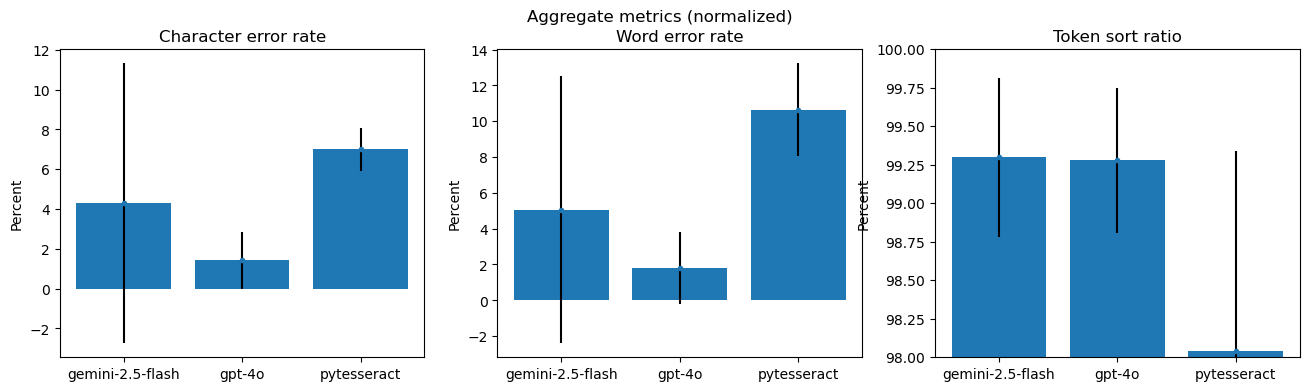

In [104]:
fig, (cer_ax, wer_ax, tsr_ax) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

cer_pct = llm_txt_grouped_mean.loc['llm-img2txt', 'normalized', 'cer_pct']
wer_pct = llm_txt_grouped_mean.loc['llm-img2txt', 'normalized', 'wer_pct']
tsr_pct = llm_txt_grouped_mean.loc['llm-img2txt', 'normalized', 'token_sort_ratio']
models = ['gemini-2.5-flash', 'gpt-4o', 'pytesseract']

cer_std = llm_txt_grouped_std.loc['llm-img2txt', 'normalized', 'cer_pct']
wer_std = llm_txt_grouped_std.loc['llm-img2txt', 'normalized', 'wer_pct']
tsr_std = llm_txt_grouped_std.loc['llm-img2txt', 'normalized', 'token_sort_ratio']

print(cer_pct)

fig.suptitle('Aggregate metrics (normalized)')

cer_ax.errorbar(models, cer_pct, yerr=cer_std, ecolor='black', fmt='.')
cer_ax.bar(models, cer_pct)
cer_ax.set_title('Character error rate')
cer_ax.set_ylabel('Percent')
wer_ax.errorbar(models, wer_pct, yerr=wer_std, ecolor='black', fmt='.')
wer_ax.bar(models, wer_pct)
wer_ax.set_title('Word error rate')
wer_ax.set_ylabel('Percent')
tsr_ax.errorbar(models, tsr_pct, yerr=tsr_std, ecolor='black', fmt='.')
tsr_ax.bar(models, tsr_pct)
tsr_ax.set_title('Token sort ratio')
tsr_ax.set_ylabel('Percent')
tsr_ax.set_ylim(np.floor(np.min(tsr_pct)), 100)

# Histogram of error rates across individual pages

In [125]:
# Get all CER rates of individual pages
all_cer_pct = llm_txt[
    ~txt_all_docs &
    (llm_txt['metric'] == 'cer_pct') &
    (llm_txt['cleaning_method'] == 'normalized') &
    (llm_txt['sub_dir'] == 'ocr-llm-img2txt')
]
all_wer_pct = llm_txt[
    ~txt_all_docs &
    (llm_txt['metric'] == 'wer_pct') &
    (llm_txt['cleaning_method'] == 'normalized') &
    (llm_txt['sub_dir'] == 'ocr-llm-img2txt')
]

10.0


Text(0.5, 0, 'Character error rate (%)')

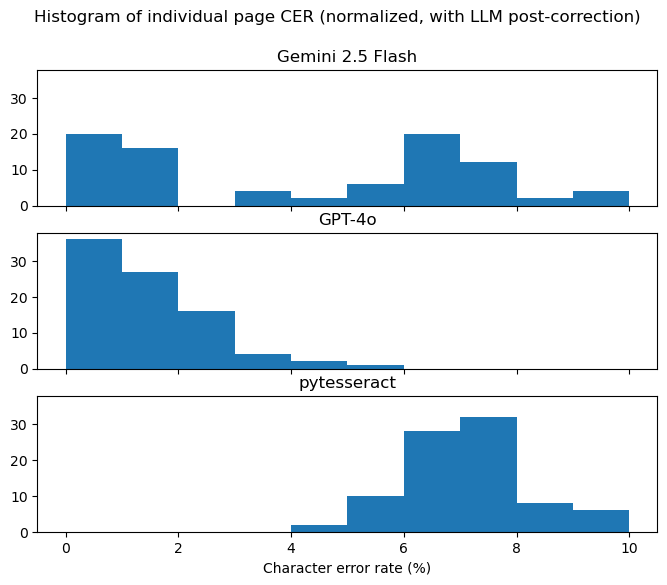

In [120]:
# Compare error rates of different models/methods
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), sharex=True, sharey=True)
fig.suptitle('Histogram of individual page CER (normalized, with LLM post-correction)')

print(np.ceil(np.max(all_cer_pct.drop(DF_INFO_COLS, axis='columns'))))

bin_width_even = range(0, int(np.ceil(np.max(all_cer_pct.drop(DF_INFO_COLS, axis='columns'))) + 1), 1)

ax0.hist(all_cer_pct['gemini-2.5-flash'], bins=bin_width_even)
ax0.set_title('Gemini 2.5 Flash')
ax1.hist(all_cer_pct['gpt-4o'], bins=bin_width_even)
ax1.set_title('GPT-4o')
ax2.hist(all_cer_pct['pytesseract'], bins=bin_width_even)
ax2.set_title('pytesseract')
ax2.set_xlabel('Character error rate (%)')

# Bar graph displaying frequencies of CER by category

In [169]:
def er_freqs_from(df):
    error_rates_only = df.drop(columns=DF_INFO_COLS)
    er_less_than_1 = (error_rates_only < 1).sum()
    er_between_1_5 = ((error_rates_only >= 1) & (error_rates_only < 5)).sum()
    er_greater_than_5 = (error_rates_only >= 5).sum()
    er_combined = pd.DataFrame({
        "error <1%": er_less_than_1,
        "1% <= error < 5%": er_between_1_5,
        "error >= 5%": er_greater_than_5
    }).transpose()
    return er_combined
cer_combined = er_freqs_from(all_cer_pct)
wer_combined = er_freqs_from(all_wer_pct)

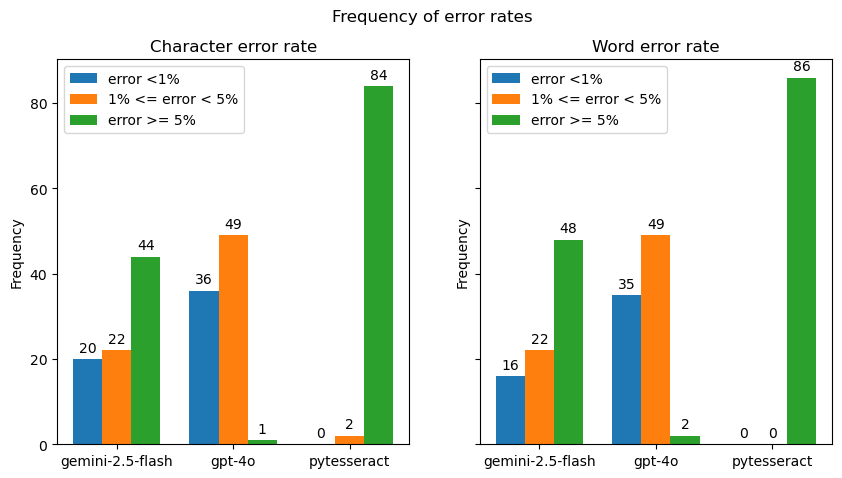

In [174]:
# Similar histogram as above, but uses separately-sized bins.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

models = ['gemini-2.5-flash', 'gpt-4o', 'pytesseract']

fig.suptitle('Frequency of error rates')

# cer_ax.bar(models, cer_pct)
for ax, data, title in zip(
    axes,
    [cer_combined, wer_combined],
    ["Character error rate", "Word error rate"]
):
    width = 0.25
    multiplier = 0

    x = np.arange(len(models))

    ax.set_title(title)
    ax.set_ylabel('Frequency')
    for index, row in data.iterrows():
        offset = width * multiplier
        rects = ax.bar(x + offset, row, width, label=index)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xticks(x + width, models)
    ax.legend(loc='upper left')